In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.add import UnaryAdd
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def add_test(rng="Sobol", row=128, col=10000, bitwidth=8):
    modes = ["bipolar", "unipolar"]

    scaled = [True, False]
    result_pe = []
    bstype = torch.float
    buftype = torch.float
    randtype = torch.float

    for mode in modes:
        for scale in scaled:
            run_time = 0
            acc_dim = 0
            result_pe_cycle = []
            uadd = UnaryAdd(bitwidth=bitwidth, mode=mode, scaled=scale, acc_dim=acc_dim).to(device)

            if mode is "unipolar":
                iVec = torch.rand(row, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
            elif mode is "bipolar":
                iVec = torch.rand(row, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
            
            oVec = torch.sum(iVec, acc_dim).to(device)

            if scale is False:
                oVec = oVec.clamp(-1.,1.).mul(2**bitwidth).floor()/2**bitwidth
            else:
                if acc_dim == 0:
                    oVec = oVec.div(row).mul(2**bitwidth).floor()/2**bitwidth
                elif acc_dim == 1:
                    oVec = oVec.div(col).mul(2**bitwidth).floor()/2**bitwidth

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, randtype=randtype)().to(device)

            iVecRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, bstype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            oVecPE = ProgressiveError(oVec, mode=mode).to(device)

            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                for i in range(2**bitwidth):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)
                    
                    start_time = time.time()
                    oVecU = uadd(iBS)
                    run_time = time.time() - start_time + run_time
                    
                    oVecPE.Monitor(oVecU)
                    result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/col).item())
                print("--- %s seconds ---" % (run_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item())
                result_pe = oVecPE()[1].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()

--- 0.136002779006958 seconds ---
input error:  min: -0.0078125 max: 0.00390625
output error:  min: -0.0078125 max: 0.00390625
error distribution=========>


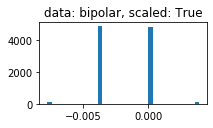

progressive accuracy=========>


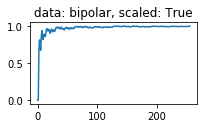

--- 0.13899564743041992 seconds ---
input error:  min: -0.0078125 max: 0.00390625
output error:  min: -0.97265625 max: 0.234375
error distribution=========>


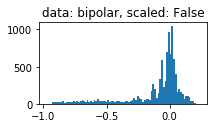

progressive accuracy=========>


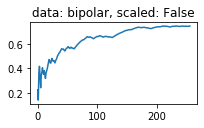

--- 0.1069936752319336 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.00390625 max: 0.0
error distribution=========>


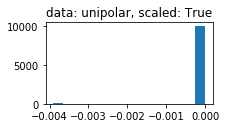

progressive accuracy=========>


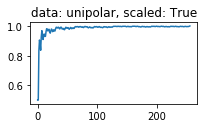

--- 0.110992431640625 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


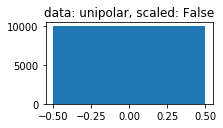

progressive accuracy=========>


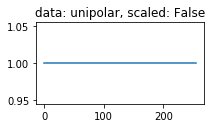

In [5]:
rng = "Sobol"
row = 128
col = 10000
bitwidth = 8
add_test(rng, row, col, bitwidth)

--- 0.13898491859436035 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.0078125 max: 0.00390625
error distribution=========>


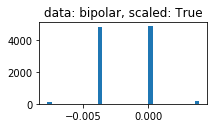

progressive accuracy=========>


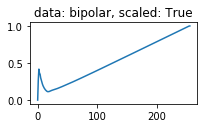

--- 0.15799880027770996 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.0078125 max: 1.96875
error distribution=========>


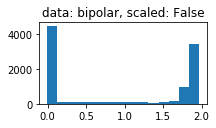

progressive accuracy=========>


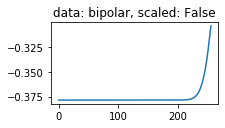

--- 0.1160116195678711 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


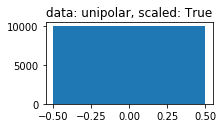

progressive accuracy=========>


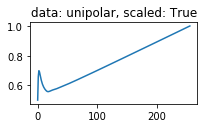

--- 0.15898704528808594 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


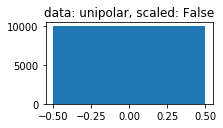

progressive accuracy=========>


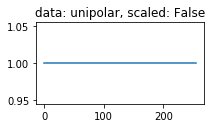

In [6]:
rng = "Race"
row = 128
col = 10000
add_test(rng, row, col)

--- 0.14501571655273438 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.01171875 max: 0.0
error distribution=========>


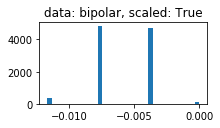

progressive accuracy=========>


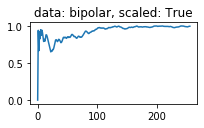

--- 0.14101743698120117 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.8984375 max: 0.9140625
error distribution=========>


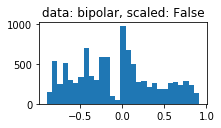

progressive accuracy=========>


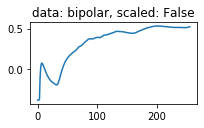

--- 0.1110084056854248 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.00390625 max: 0.0
error distribution=========>


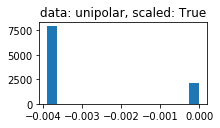

progressive accuracy=========>


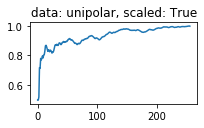

--- 0.11598896980285645 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


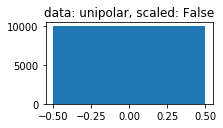

progressive accuracy=========>


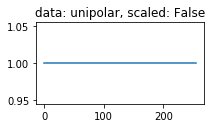

In [7]:
rng = "LFSR"
row = 128
col = 10000
add_test(rng, row, col)

--- 0.13900160789489746 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.0078125 max: 0.00390625
error distribution=========>


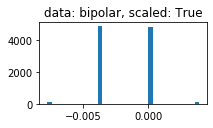

progressive accuracy=========>


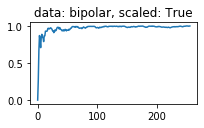

--- 0.13600754737854004 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.25 max: 1.703125
error distribution=========>


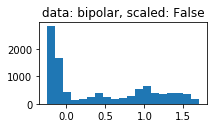

progressive accuracy=========>


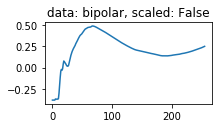

--- 0.11100625991821289 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0
error distribution=========>


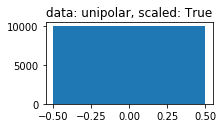

progressive accuracy=========>


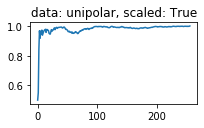

--- 0.1180107593536377 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.00390625 max: 0.0
error distribution=========>


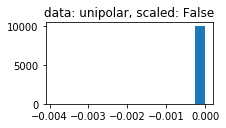

progressive accuracy=========>


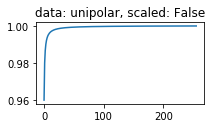

In [8]:
rng = "SYS"
row = 128
col = 10000
add_test(rng, row, col)